In [1]:
# Basic operations
import numpy as np
import pandas as pd
import gensim
from importlib import reload

# LDA
from collections import Counter

import pylab as pl
# aesthetics
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from source import topic_modelling as tm

C:\Python_files\zipf-law-for-information-theory\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
First, we will perform classical exploratory analysis.
"""

df = pd.read_pickle('dfs/preprocessed-cleaned-df.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54190 entries, 0 to 11903
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt           54190 non-null  object
 1   professor        54190 non-null  object
 2   student          54190 non-null  object
 3   professor_clean  54190 non-null  object
 4   student_clean    54190 non-null  object
 5   prompt_clean     54190 non-null  object
dtypes: object(6)
memory usage: 2.9+ MB


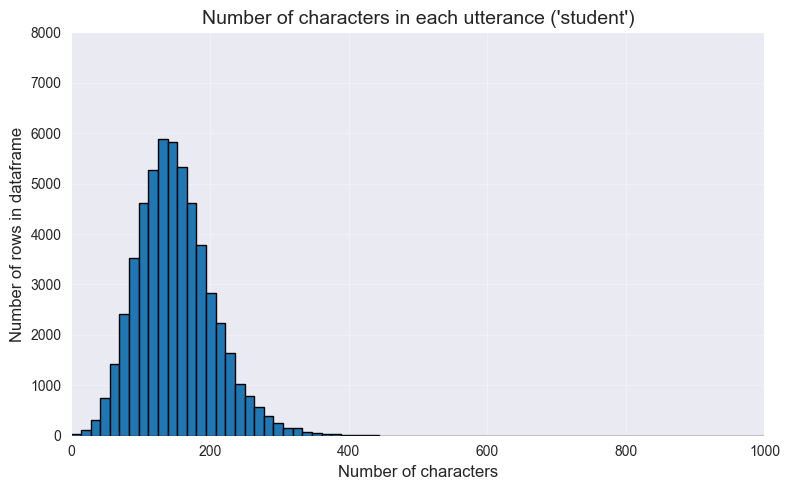

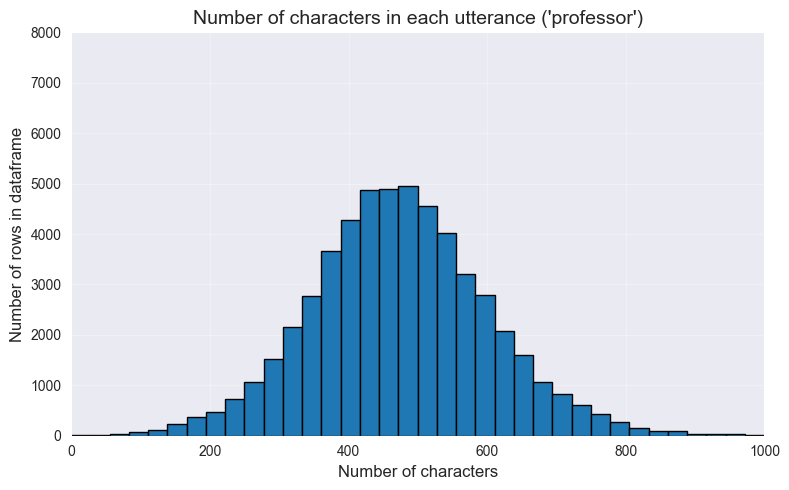

In [3]:
# number of characters in each utterance of each speaker
for column in ['student', 'professor']:
    plt.figure(figsize=(8, 5))
    df[column].str.len().hist(bins=300, edgecolor='black')
    plt.title(f"Number of characters in each utterance ('{column}')", fontsize=14)
    plt.xlim(0, 1000)
    plt.ylim(0, 8000)
    plt.xlabel("Number of characters", fontsize=12)
    plt.ylabel("Number of rows in dataframe", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

C:\Python_files\zipf-law-for-information-theory\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Python_files\zipf-law-for-information-theory\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


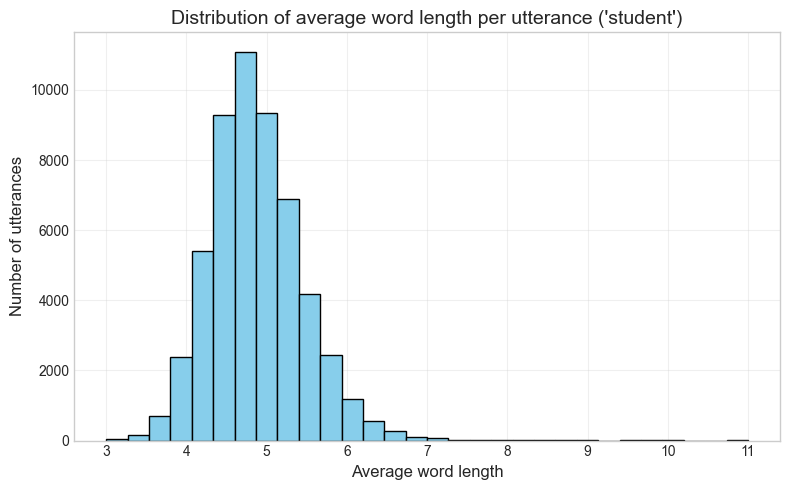

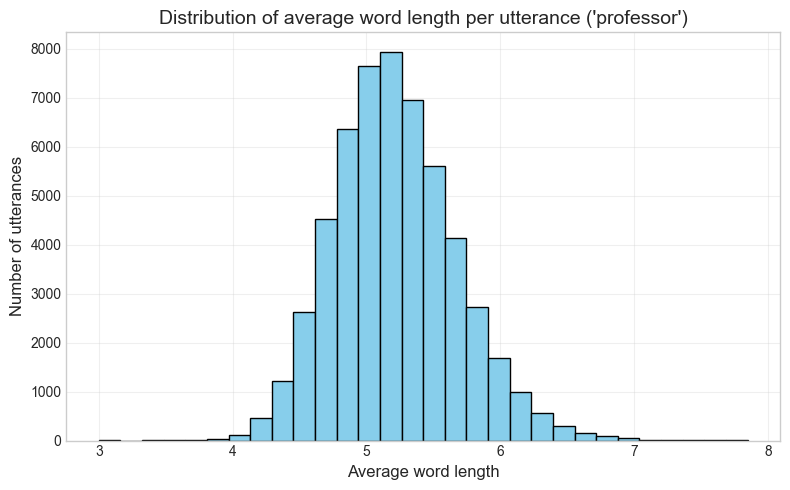

In [4]:
# distribution of average word length per utterance
plt.style.use('seaborn-v0_8-whitegrid')
for column in ['student', 'professor']:
    plt.figure(figsize=(8, 5))
    df[column].str.split() \
        .apply(lambda x: [len(i) for i in x]) \
        .map(np.mean) \
        .hist(bins=30, edgecolor='black', color='skyblue')

    plt.title(f"Distribution of average word length per utterance ('{column}')", fontsize=14)
    plt.xlabel("Average word length", fontsize=12)
    plt.ylabel("Number of utterances", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

C:\Users\quiz0\AppData\Local\Temp\ipykernel_23332\2081902539.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="mako")


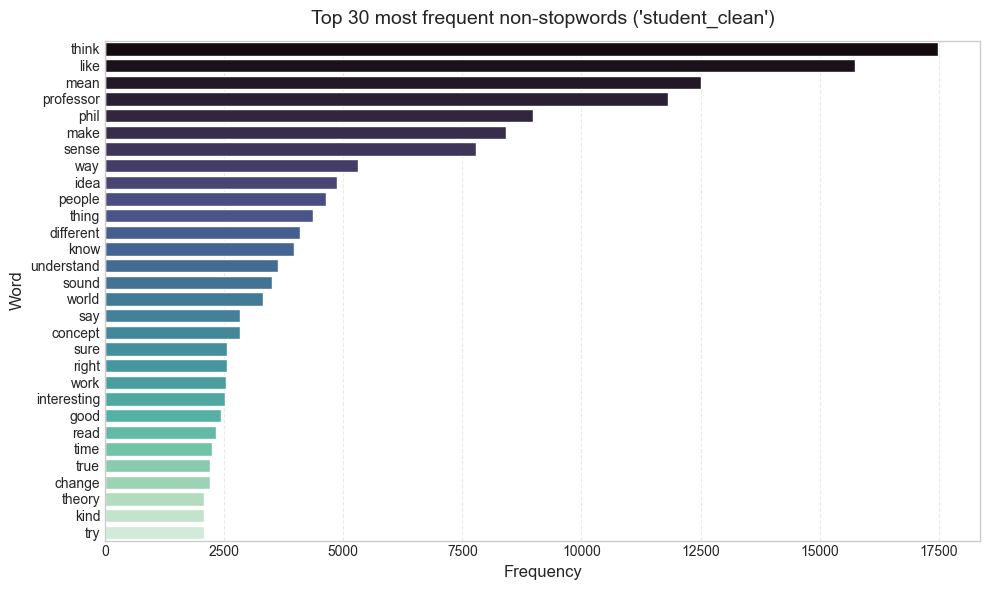

C:\Users\quiz0\AppData\Local\Temp\ipykernel_23332\2081902539.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="mako")


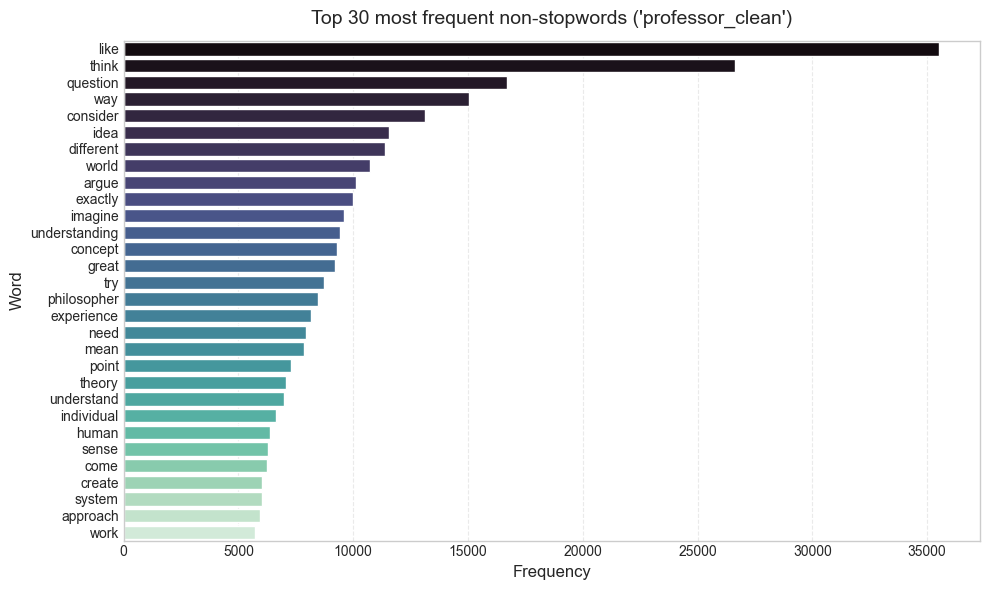

In [5]:
# The 30 most popular words
for column in ['student_clean', 'professor_clean']:
    corpus = [word for lemmas in df[column] for word in lemmas]
    counter=Counter(corpus)
    most=counter.most_common(30)
    words, counts = zip(*most)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="mako")
    plt.title(f"Top {30} most frequent non-stopwords ('{column}')", fontsize=14, pad=12)
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Word", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [6]:
"""
Now it's time for topic modelling
"""
texts = df['professor_clean'] + df['student_clean']
dic=gensim.corpora.Dictionary(texts)
bow_corpus = [dic.doc2bow(doc) for doc in texts] # BOW

In [7]:
# Search the space for the best solution
ev_metric = tm.find_best_LDA(
    corpus=bow_corpus,
    id2word=dic,
    passes=40,
    texts=texts,
    coherence='c_v',
    n_trials=50
)
ev_metric.to_csv(f'dfs/LDA_ev_metric.csv')

[I 2026-02-08 14:49:27,333] A new study created in memory with name: LDA-topic-modelling
[W 2026-02-08 14:50:09,914] Trial 0 failed with parameters: {'num_topics': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Python_files\zipf-law-for-information-theory\.venv\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Python_files\zipf-law-for-information-theory\source\topic_modelling.py", line 32, in single_study
    model = create_LDA_model(
        corpus=corpus,
    ...<2 lines>...
        passes=passes
    )
  File "C:\Python_files\zipf-law-for-information-theory\source\topic_modelling.py", line 12, in create_LDA_model
    lda_model = gensim.models.LdaMulticore(corpus,
                                           num_topics=num_topics,
                                           id2word=id2word,
                                           passes=passes,
                     

KeyboardInterrupt: 

In [31]:
ev_metric = pd.read_csv(f'dfs/LDA_ev_metric.csv')
ev_metric.sort_values('coherence_score').head()

,Unnamed: 0,number,coherence_score,datetime_start,datetime_complete,duration,params_num_topics,state
23,23,23,0.396192,2026-01-18 11:21:47.416870,2026-01-18 11:22:28.047315,0 days 00:00:40.630445,2,COMPLETE
27,27,27,0.396772,2026-01-18 11:24:27.076934,2026-01-18 11:25:05.958510,0 days 00:00:38.881576,8,COMPLETE
18,18,18,0.400044,2026-01-18 11:18:27.512878,2026-01-18 11:19:06.920433,0 days 00:00:39.407555,5,COMPLETE
33,33,33,0.405828,2026-01-18 11:28:21.317056,2026-01-18 11:29:00.327681,0 days 00:00:39.010625,18,COMPLETE
37,37,37,0.407849,2026-01-18 11:30:59.930573,2026-01-18 11:31:40.370897,0 days 00:00:40.440324,16,COMPLETE


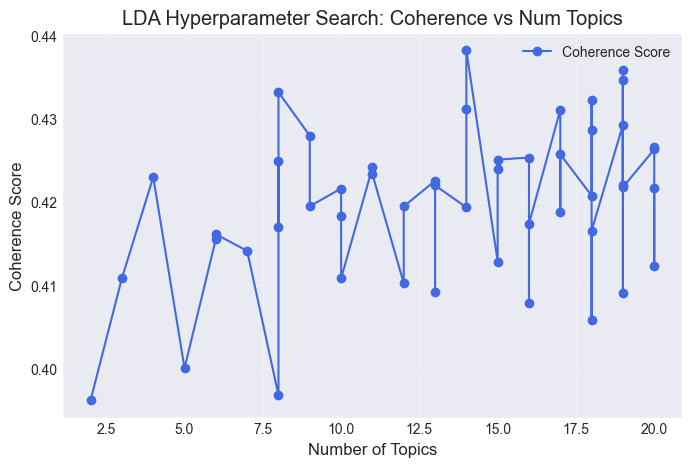

In [33]:
 tm.plot_LDA_search_results(ev_metric)

In [10]:
# run the best LDA model
best_lda = tm.create_LDA_model(corpus=bow_corpus,
                                num_topics=8,
                                id2word=dic,
                                passes=100)

In [11]:
# plot the results
tm.plot_lda_vis(lda_model=best_lda,
                corpus=bow_corpus,
                dic=dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.080313  0.052051       1        1  17.413106
6      0.061003 -0.013775       2        1  14.730697
2     -0.039181 -0.160534       3        1  12.234095
5      0.002598  0.125302       4        1  11.155747
7     -0.184039 -0.136824       5        1  10.607164
1      0.227105 -0.079280       6        1  10.406912
8     -0.047743  0.141592       7        1   9.849696
4     -0.133396  0.076492       8        1   7.279677
3      0.033339 -0.005023       9        1   6.322904, topic_info=              Term          Freq         Total Category  logprob  loglift
29       professor  11175.000000  11175.000000  Default  30.0000  30.0000
507       language   6042.000000   6042.000000  Default  29.0000  29.0000
139           phil   8434.000000   8434.000000  Default  28.0000  28.0000
110          world  13918.000000  13918.000000  Default  27.0000  27.0000
482          moral   6929.000000   6929.000000  Default  26.0000  26.0000
..             ...           ...           ...      ...      ...      ...
74         concept    994.998325  12053.885244   Topic9  -5.0635   0.2666
86            make    967.592959  13420.126197   Topic9  -5.0914   0.1313
119       consider    853.451977  14198.801625   Topic9  -5.2169  -0.0506
169          point    786.595327   9334.006600   Topic9  -5.2985   0.2873
242  understanding    771.259401  11506.619923   Topic9  -5.3182   0.0583

[713 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
370       2  0.632945  abstract
370       3  0.036561  abstract
370       7  0.207181  abstract
370       8  0.046390  abstract
370       9  0.077054  abstract
...     ...       ...       ...
1551      2  0.877927       wow
1551      7  0.119256       wow
1228      6  0.995816    writer
989       6  0.948047   writing
989       9  0.048797   writing

[1731 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 3, 6, 8, 2, 9, 5, 4])

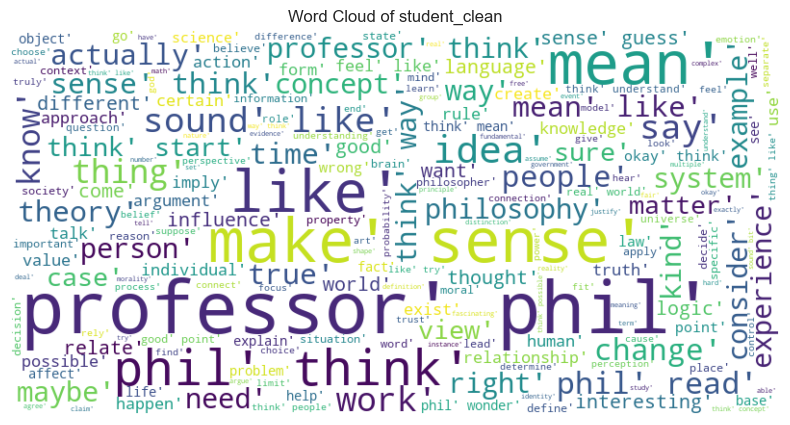

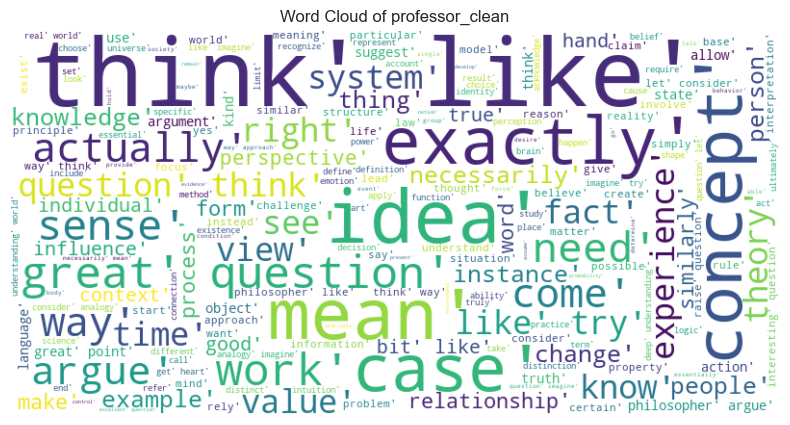

In [12]:
# generate wordclouds
for column in ['student_clean', 'professor_clean']:
    wd_text = " ".join(df[column].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wd_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of {column}")
    plt.show()

In [13]:
df = pd.read_pickle('dfs/preprocessed-cleaned-df.pkl')
# df = pd.read_csv('dfs/preprocessed-cleaned-df.csv', delimiter=';')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54190 entries, 0 to 11903
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt           54190 non-null  object
 1   professor        54190 non-null  object
 2   student          54190 non-null  object
 3   professor_clean  54190 non-null  object
 4   student_clean    54190 non-null  object
 5   prompt_clean     54190 non-null  object
dtypes: object(6)
memory usage: 2.9+ MB


In [15]:
df = pd.read_pickle('dfs/preprocessed-cleaned-df.pkl')
# set ID for each conversation
df['conversation_id'] = df.index

# index for each row
df['row_id'] = np.arange(len(df)) + 1
df.set_index('row_id', inplace=True)

df.dropna(inplace = True, subset=['student', 'professor'])

In [16]:
import re

def clean_text(text):
    text = re.sub(r'(\n\d+\s+)|\d\s*', ' ', text)
    text = re.sub(r"(\'|%)", '', text)
    text = re.sub(r"\W", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    return text.lower()


# text = df['student'].to_string()
# clean_text(text)[12:270]

In [17]:
"""
3) Compute Zip's law distribution
"""
from source import zipfslaw as zl
import re

reload(zl)
prof_text = clean_text(df['professor'].to_string())
stud_text = clean_text(df['student'].to_string())

print("-----------------")
print("| Zipf's Law    |")
try:
    text = prof_text + stud_text
    zipf_table = zl.generate_zipf_table(text, 200)
    zl.print_zipf_table(zipf_table)
except IOError as e:
    print(e)

C:\Python_files\zipf-law-for-information-theory\source\zipfslaw.py:27: SyntaxWarning: invalid escape sequence '\]'
  !\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789
C:\Python_files\zipf-law-for-information-theory\source\zipfslaw.py:31: SyntaxWarning: invalid escape sequence '\]'
  chars_to_remove = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789"
C:\Python_files\zipf-law-for-information-theory\source\zipfslaw.py:27: SyntaxWarning: invalid escape sequence '\]'
  !\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789
C:\Python_files\zipf-law-for-information-theory\source\zipfslaw.py:31: SyntaxWarning: invalid escape sequence '\]'
  chars_to_remove = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789"


-----------------
| Zipf's Law    |
--------------------------------------------------------------------------------
|Rank|    Word    |Actual Freq | Zipf Frac  | Zipf Freq  |Actual Diff |Pct Diff|
--------------------------------------------------------------------------------
|   1|a           |       38481|         1/1|    38481.00|        0.00| 100.00%|
|   2|the         |       30969|         1/2|    19240.50|    11728.50| 160.96%|
|   3|thats       |       29749|         1/3|    12827.00|    16922.00| 231.92%|
|   4|i           |       27807|         1/4|     9620.25|    18186.75| 289.05%|
|   5|that        |       24850|         1/5|     7696.20|    17153.80| 322.89%|
|   6|but         |       22905|         1/6|     6413.50|    16491.50| 357.14%|
|   7|of          |       20911|         1/7|     5497.29|    15413.71| 380.39%|
|   8|what        |       16445|         1/8|     4810.12|    11634.88| 341.88%|
|   9|it          |       14732|         1/9|     4275.67|    10456.33| 3

In [19]:
"""
4.1) Entropy on the char level
"""
from source import entropy as ep
reload(ep)
df = ep.compute_entropy_dataset(df, ['student', 'professor'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54190 entries, 1 to 54190
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prompt           54190 non-null  object 
 1   professor        54190 non-null  object 
 2   student          54190 non-null  object 
 3   professor_clean  54190 non-null  object 
 4   student_clean    54190 non-null  object 
 5   prompt_clean     54190 non-null  object 
 6   conversation_id  54190 non-null  int64  
 7   student_ent      54190 non-null  float64
 8   professor_ent    54190 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 4.1+ MB


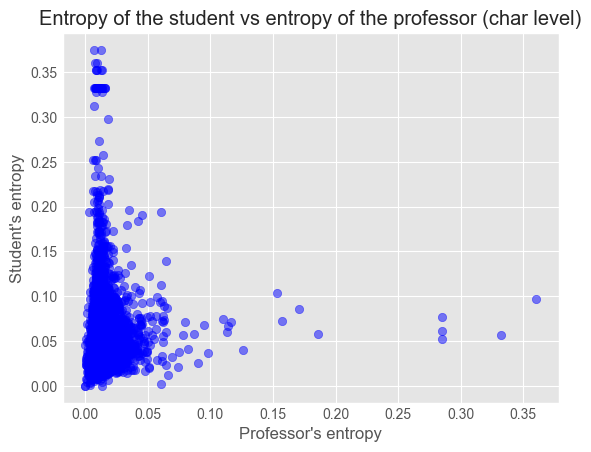

In [20]:
plt.style.use('ggplot')
fig, ax = plt.subplots()

ax.scatter(df['professor_ent'], df['student_ent'], color='blue', alpha=0.5)
plt.xlabel("Professor's entropy")
plt.ylabel("Student's entropy")
plt.title("Entropy of the student vs entropy of the professor (char level)")
plt.show()

In [21]:
df.sort_values('professor_ent', ascending=False, inplace=False).head(5)

,prompt,professor,student,professor_clean,student_clean,prompt_clean,conversation_id,student_ent,professor_ent
row_id,,,,,,,,,
18055,\n Perhaps the best known attack on the sugges...,Me too.,I look forward to exploring that further.,[],"[look, forward, explore]","[well, know, attack, suggestion, ture, test, p...",4038,0.09692,0.36023
52390,\n We find ourselves naturally inclined to mak...,Of course.,"Alright, I think I'll have to mull this over. ...",[course],"[alright, think, mull, ask, question]","[find, naturally, inclined, certain, judgment,...",11633,0.05638,0.33219
53114,\n\n At the end of 1937 Prior set aside though...,My pleasure!,"Thank you for such insightful discussions, Pro...",[pleasure],"[thank, insightful, discussion, professor]","[end, prior, set, aside, thought, academic, ca...",11747,0.07670,0.28486
6016,\n A closely related feature is that most conc...,My pleasure!,I'd love to explore that more in our next conv...,[pleasure],"[love, explore, conversation, thank, professor...","[closely, relate, feature, conception, common,...",1313,0.05203,0.28486
25726,The idea of the moral point of view can be tra...,My pleasure!,"Alright, I think I see how it could be useful....",[pleasure],"[alright, think, useful, thank, professor, phil]","[idea, moral, point, view, trace, david, hume,...",5763,0.06142,0.28486


In [22]:
df.sort_values('student_ent', ascending=False, inplace=False).head(5)

,prompt,professor,student,professor_clean,student_clean,prompt_clean,conversation_id,student_ent,professor_ent
row_id,,,,,,,,,
2137,\n Amartya Sen extended Arrow’s framework by ...,"Well, imagine that we have two people, Alice a...",Why not?,"[imagine, people, alice, bob, ask, rate, prefe...",[],"[amartya, sen, extend, arrow, framework, repre...",463,0.37500,0.00730
50389,\n\n How might one reply to the arguments for ...,"For instance, think about sentences like ""It i...",Such as?,"[instance, think, sentence, like, rain, god, e...",[],"[reply, argument, proposition, discuss, reply,...",11283,0.37500,0.01304
32506,\n The emergence of systems biology and synthe...,Consider the traditional hypothesis-driven app...,How so?,"[consider, traditional, hypothesis, drive, app...",[],"[emergence, system, biology, synthetic, biolog...",7288,0.36023,0.00808
26868,\n Women were probably more active in Pythagor...,"Well, if we look at the Pythagorean movement, ...",How so?,"[look, pythagorean, movement, woman, equally, ...",[],"[woman, probably, active, pythagoreanism, anci...",6019,0.36023,0.00910
45083,\n\n Versions of the Fregean argument are some...,"Well, some philosophers argue that just becaus...",Like who?,"[philosopher, argue, use, mathematical, langua...",[like],"[versions, fregean, argument, state, term, not...",10108,0.35221,0.00931


In [23]:
df.sort_values(['student_ent', 'professor_ent'], ascending=False, inplace=False).head(5)

,prompt,professor,student,professor_clean,student_clean,prompt_clean,conversation_id,student_ent,professor_ent
row_id,,,,,,,,,
50389,\n\n How might one reply to the arguments for ...,"For instance, think about sentences like ""It i...",Such as?,"[instance, think, sentence, like, rain, god, e...",[],"[reply, argument, proposition, discuss, reply,...",11283,0.37500,0.01304
2137,\n Amartya Sen extended Arrow’s framework by ...,"Well, imagine that we have two people, Alice a...",Why not?,"[imagine, people, alice, bob, ask, rate, prefe...",[],"[amartya, sen, extend, arrow, framework, repre...",463,0.37500,0.00730
26868,\n Women were probably more active in Pythagor...,"Well, if we look at the Pythagorean movement, ...",How so?,"[look, pythagorean, movement, woman, equally, ...",[],"[woman, probably, active, pythagoreanism, anci...",6019,0.36023,0.00910
32506,\n The emergence of systems biology and synthe...,Consider the traditional hypothesis-driven app...,How so?,"[consider, traditional, hypothesis, drive, app...",[],"[emergence, system, biology, synthetic, biolog...",7288,0.36023,0.00808
6088,\n Compatibilism’s place in contemporary philo...,"Well, imagine three gardeners, each nurturing ...",Like who?,"[imagine, gardener, nurture, different, branch...",[like],"[compatibilism, place, contemporary, philosoph...",1329,0.35221,0.01377


In [24]:
# high for student and professor
student_threshold = df['student_ent'].quantile(0.95)
professor_threshold = df['professor_ent'].quantile(0.95)

high_entropy= df[
    (df['student_ent'] >= student_threshold) &
    (df['professor_ent'] >= professor_threshold)
]

high_entropy.head()

,prompt,professor,student,professor_clean,student_clean,prompt_clean,conversation_id,student_ent,professor_ent
row_id,,,,,,,,,
207,Two doctrines dominate philosophical and psych...,Exactly! That's the beauty of philosophy – it ...,I never thought about it that way.,"[exactly, beauty, philosophy, encourage, quest...","[think, way]","[doctrine, dominate, philosophical, psychologi...",48,0.10938,0.01699
272,\n\n Whether or not the non-locality predicted...,"Yes, it is. The debate continues, and it's an ...","So, it's still an open question?","[yes, debate, continue, active, area, research...","[open, question]","[non, locality, predict, quantum, theory, clas...",62,0.11779,0.02031
393,The debate over adaptationism is often traced ...,"You see, this debate is not just about the sci...","I think I'm starting to get it. Thanks, Profes...","[debate, scientific, fact, understanding, evol...","[think, start, thank, professor, phil]","[debate, adaptationism, trace, paper, stephen,...",89,0.07501,0.01887
452,\n\n The most straightforward challenge emphas...,I'm glad I could help clarify things for you! ...,That makes a lot of sense. I never thought abo...,"[glad, help, clarify, thing, philosophy, chall...","[make, lot, sense, think, way]","[straightforward, challenge, emphasize, decisi...",101,0.06474,0.02214
563,"3.3 Disappearing agents, naturalism, and dual ...",Exactly! That's the whole point of philosophy ...,"Alright, Professor, I think I need to think ab...","[exactly, point, philosophy, question, assumpt...","[alright, professor, think, need, think]","[disappear, agent, naturalism, dual, standpoin...",126,0.06459,0.02047


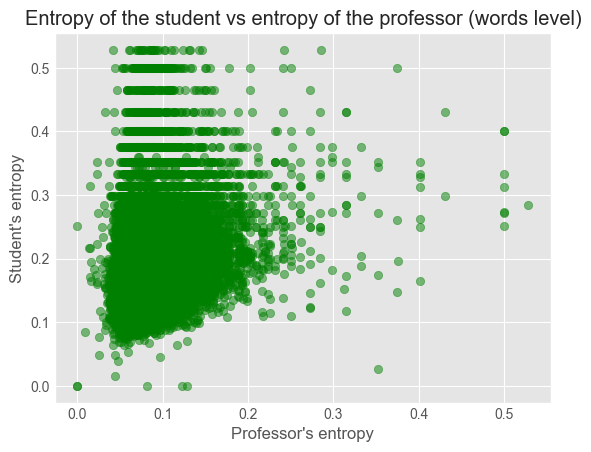

In [25]:
"""
4.2) Entropy on the word level
"""
df['professor_words'] = df['professor'].apply(lambda x: x.split())
df['student_words'] = df['student'].apply(lambda x: x.split())
df = ep.compute_entropy_dataset(df, ['professor_words', 'student_words'])

plt.style.use('ggplot')
fig, ax = plt.subplots()

ax.scatter(df['professor_words_ent'], df['student_words_ent'], color='green', alpha=0.5)
plt.xlabel("Professor's entropy")
plt.ylabel("Student's entropy")
plt.title("Entropy of the student vs entropy of the professor (words level)")
plt.show()

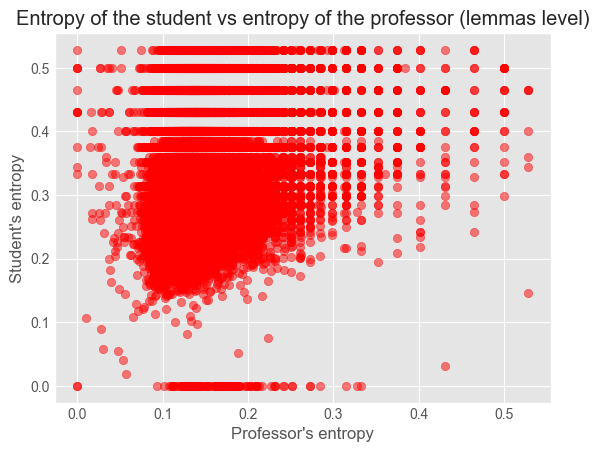

In [26]:
"""
4.2) Entropy on the word level
"""
from source import entropy as ep
reload(ep)
df = ep.compute_entropy_dataset(df, ['professor_clean', 'student_clean'])

plt.style.use('ggplot')
fig, ax = plt.subplots()

ax.scatter(df['professor_clean_ent'], df['student_clean_ent'], color='red', alpha=0.5)
plt.xlabel("Professor's entropy")
plt.ylabel("Student's entropy")
plt.title("Entropy of the student vs entropy of the professor (lemmas level)")


plt.show()

In [27]:
df.sort_values('professor_clean_ent', ascending=False, inplace=False).head(5)

,prompt,professor,student,professor_clean,student_clean,prompt_clean,conversation_id,student_ent,professor_ent,professor_words,student_words,professor_words_ent,student_words_ent,professor_clean_ent,student_clean_ent
row_id,,,,,,,,,,,,,,,
52689,\n The dual framework ‘proximate vs. ultimate’...,"That's the power of philosophy, my friend!","That's really inspiring, Professor. I never th...","[power, philosophy, friend]","[inspiring, professor, think, abstract, concep...","[dual, framework, proximate, ultimate, provide...",11680,0.03609,0.09833,"[That's, the, power, of, philosophy,, my, frie...","[That's, really, inspiring,, Professor., I, ne...",0.40105,0.25000,0.52832,0.40105
7210,\n\n \t \t\t \t\t\tP1. \t\t\tI don’t know that...,Excellent! That's all anyone can ask for in ph...,"Yeah, I think so. I need to think about it som...","[excellent, ask, philosophy]","[yeah, think, need, think, feel, like, well, h...","[know, know, know, know, constitute, puzzle, p...",1576,0.03778,0.07500,"[Excellent!, That's, all, anyone, can, ask, fo...","[Yeah,, I, think, so., I, need, to, think, abo...",0.35221,0.17368,0.52832,0.34375
21542,3.2 Totality and Revolution It is easy to see ...,"The pleasure is mine, my inquisitive student!","Thank you, Professor Phil. This conversation h...","[pleasure, inquisitive, student]","[thank, professor, phil, conversation, enlight...","[totality, revolution, easy, result, conceptio...",4821,0.05810,0.08708,"[The, pleasure, is, mine,, my, inquisitive, st...","[Thank, you,, Professor, Phil., This, conversa...",0.40105,0.33219,0.52832,0.46439
24395,"\n Mach, James, and Russell agree that neutral...","That's what I'm here for. Now, go think about ...","Thank you, Professor. You've given me a lot to...","[think, challenge, thought]","[thank, professor, give, lot, think]","[mach, james, russell, agree, neutral, monism,...",5463,0.07180,0.05304,"[That's, what, I'm, here, for., Now,, go, thin...","[Thank, you,, Professor., You've, given, me, a...",0.26046,0.31449,0.52832,0.46439
10057,\n The first book-length study thematizing Du ...,"No problem, I'm glad I could help!","Thanks, Professor. That really helps clarify t...","[problem, glad, help]","[thank, professor, help, clarify, thing]","[book, length, study, thematize, boisian, doub...",2214,0.07077,0.11653,"[No, problem,, I'm, glad, I, could, help!]","[Thanks,, Professor., That, really, helps, cla...",0.40105,0.35221,0.52832,0.46439


In [28]:
df.sort_values(['student_clean_ent', 'professor_ent'], ascending=False, inplace=False).head(5)

,prompt,professor,student,professor_clean,student_clean,prompt_clean,conversation_id,student_ent,professor_ent,professor_words,student_words,professor_words_ent,student_words_ent,professor_clean_ent,student_clean_ent
row_id,,,,,,,,,,,,,,,
18055,\n Perhaps the best known attack on the sugges...,Me too.,I look forward to exploring that further.,[],"[look, forward, explore]","[well, know, attack, suggestion, ture, test, p...",4038,0.09692,0.36023,"[Me, too.]","[I, look, forward, to, exploring, that, further.]",0.50000,0.40105,0.00000,0.52832
14336,\n Jeremy Bentham’s Handbook of Political Fall...,"It was a thought-provoking conversation, keep ...","Alright, thank you, Professor.","[thought, provoke, conversation, think, critic...","[alright, thank, professor]","[jeremy, bentham, handbook, political, fallaci...",3191,0.13882,0.06440,"[It, was, a, thought-provoking, conversation,,...","[Alright,, thank, you,, Professor.]",0.37500,0.50000,0.46439,0.52832
16286,\n Hazlitt famously described Godwin’s reputat...,"My pleasure, always happy to explore these com...","Professor, that's really helpful. Thank you.","[pleasure, happy, explore, complex, idea]","[professor, helpful, thank]","[hazlitt, famously, describe, godwin, reputati...",3637,0.09405,0.06129,"[My, pleasure,, always, happy, to, explore, th...","[Professor,, that's, really, helpful., Thank, ...",0.31449,0.43083,0.46439,0.52832
9597,\n In the second half of the twentieth century...,No problem at all – it's great to see you thin...,That's fascinating. Thank you for explaining i...,"[problem, great, think, critically, concept]","[fascinating, thank, explain]","[second, half, twentieth, century, rapid, deve...",2116,0.07722,0.04932,"[No, problem, at, all, –, it's, great, to, see...","[That's, fascinating., Thank, you, for, explai...",0.26046,0.35221,0.46439,0.52832
31388,\n The first non-spatiotemporal symmetry to be...,"Indeed, it is. And I think we've only just beg...","I see. So, it's a complex topic that's still b...","[think, begin, unravel, puzzle, sameness, phys...","[complex, topic, explore]","[non, spatiotemporal, symmetry, introduce, mic...",7036,0.06870,0.04523,"[Indeed,, it, is., And, I, think, we've, only,...","[I, see., So,, it's, a, complex, topic, that's...",0.23166,0.31449,0.43083,0.52832


In [29]:
# high for student and professor
student_threshold = df['student_clean_ent'].quantile(0.95)
professor_threshold = df['professor_clean_ent'].quantile(0.95)

high_clean_entropy= df[
    (df['student_clean_ent'] >= student_threshold) &
    (df['professor_clean_ent'] >= professor_threshold)
]

high_clean_entropy.head()

,prompt,professor,student,professor_clean,student_clean,prompt_clean,conversation_id,student_ent,professor_ent,professor_words,student_words,professor_words_ent,student_words_ent,professor_clean_ent,student_clean_ent
row_id,,,,,,,,,,,,,,,
207,Two doctrines dominate philosophical and psych...,Exactly! That's the beauty of philosophy – it ...,I never thought about it that way.,"[exactly, beauty, philosophy, encourage, quest...","[think, way]","[doctrine, dominate, philosophical, psychologi...",48,0.10938,0.01699,"[Exactly!, That's, the, beauty, of, philosophy...","[I, never, thought, about, it, that, way.]",0.12038,0.40105,0.25000,0.50000
272,\n\n Whether or not the non-locality predicted...,"Yes, it is. The debate continues, and it's an ...","So, it's still an open question?","[yes, debate, continue, active, area, research...","[open, question]","[non, locality, predict, quantum, theory, clas...",62,0.11779,0.02031,"[Yes,, it, is., The, debate, continues,, and, ...","[So,, it's, still, an, open, question?]",0.13531,0.43083,0.26046,0.50000
353,\n\n It is natural to initially diagnose the d...,The distinction is crucial for moral judgments...,Actualism and possibilism? I've never heard of...,"[distinction, crucial, moral, judgment, prescr...","[actualism, possibilism, hear, term]","[natural, initially, diagnose, disagreement, a...",82,0.06396,0.01525,"[The, distinction, is, crucial, for, moral, ju...","[Actualism, and, possibilism?, I've, never, he...",0.11441,0.33219,0.22549,0.50000
390,The debate over adaptationism is often traced ...,Exactly! And it's a debate that's been ongoing...,"So, it's like a debate then? With adaptationis...","[exactly, debate, ongoing, long, time, root, c...","[like, debate, adaptationist, pluralist]","[debate, adaptationism, trace, paper, stephen,...",89,0.04393,0.01622,"[Exactly!, And, it's, a, debate, that's, been,...","[So,, it's, like, a, debate, then?, With, adap...",0.11574,0.24219,0.23438,0.50000
393,The debate over adaptationism is often traced ...,"You see, this debate is not just about the sci...","I think I'm starting to get it. Thanks, Profes...","[debate, scientific, fact, understanding, evol...","[think, start, thank, professor, phil]","[debate, adaptationism, trace, paper, stephen,...",89,0.07501,0.01887,"[You, see,, this, debate, is, not, just, about...","[I, think, I'm, starting, to, get, it., Thanks...",0.13898,0.33219,0.28465,0.46439
